# 09 - Non Compliance and LATE

## Dipping our Toes into a Heterogeneous World

8장에서는 전통적인 관점의 `instrumental variable`(`IV`)를 공부했습니다. `IV`를 일종의 [`natural experiment`](https://en.wikipedia.org/wiki/Natural_experiment) (자연실험, 통제 밖의 다른 요인에 의해 결정되는 실험이나 통제 조건에 노출되는 경험적 연구)처럼 활용하였습니다. 의학 분야에서는 현대적인 `IV`를 통해  많은 통찰을 얻고 있습니다. `instrument`에 대한 반응에 따라 크게 4개 집단으로 나눕니다.

1. Compliers
2. Never Takers
3. Always Takers
4. Defiers

집단의 이름은 제약학에서 따왔습니다. 신약 효과를 위한 실험을 계획한다고 생각해봅시다. 개별 집단은 약이나 위약을 받습니다. `Compliers`는 지시를 잘 따르는 집단입니다. 약/위약 모두 처방받은 대로 먹습니다. `Never Takers`는 복용을 거부하는 집단입니다. 처방받은 약을 먹지 않습니다. `Always Takers`는 항상 약을 먹는 집단입니다. 위약을 할당하더라도 어떻게든 약을 구해 복용합니다. `Defiers`는 반항 집단입니다. 약을 할당하면 위약을 먹고, 위약을 할당하면 약을 먹습니다. 항상 반대로 행동하는 청개구리 같은 집단입니다. 흔치 않은 집단으로 실무에서는 자주 무시됩니다.

![img](./data/img/late/defiers.png)

현대적인 `IV`에서는 `instrument`를 `compliance`(`Compliers` 만으로 이루어짐)가 완벽하지 않은 준실험 설계로 취급합니다. 이렇게 함으로써 외부 유효 인과관계에서 내부 유효 인과관계를 분리해 낼수 있습니다. 내부 유효 인과관계는 우리가 확인할 수 있는 것 중 하나임을 강조하고 싶습니다. 내부 유효 인과관계는 특정한 데이터, 특정한 조건에서만 유효합니다. `IV`에서 내부 유효 인과관계는 `instrument`가 `treatment`를 바꿀 때 `treatment effect`입니다. 반면 외부 유효성은 인과효과의 예측력입니다. 외부 유효성은 인과효과를 다른 집단으로 일반화 가능성입니다. 예를 들어 한 대학교에서 기부에 대한 인센티브가 기부를 촉진하는지 조사하기 위해 `RCT`를 실시한다고 가정해봅시다. 실험을 잘 설계했지만, 경제학과 학생들만 참여했습니다. 그 결과 당신은 참가자 모두 이기적인 멍청이들이라는 것을 알게 됩니다. 이는 내부적으로 타당한 결론입니다. 취합한 데이터에 대해는 유효한 결과입니다. 하지만 이 실험으로 전 세계 모든 사람이 이기적이라고 할 수 있을까요? 그건 아닐 겁니다. 따라서 우리는 실험 결과를 일반화할 수 있는지(외부 타당성이 있는지) 평가할 필요가 있습니다. 다시 `IV`로 돌아가겠습니다.

예를 들어 인앱 결제로 측정한 사용자 참여를 높이려는 상황을 생각해 보겠습니다. 참여를 유도하는 한 가지 방법으로 푸시 알림을 마케팅팀에 제안합니다. 마케팅팀은 멋지고 화려한 푸시 알림을 만들었습니다. 당신은 푸시 알림으로 무작위 실험을 설계했고, 10000명의 무작위 고객 대상으로 50% 확률로 푸시 알림을 보냅니다. 하지만 테스트를 하면서 푸시 알림을 받게 되어있는 고객 중 일부가 알림을 받지 않는다는 사실을 알게 되었습니다. 엔지니어는 구형 스마트폰에서는 푸시를 지원하지 않기 때문이라고 합니다.

큰 문제는 아니라고 생각할지도 모릅니다. 푸시 알림을 받지 못한 고객은 푸시 알림을 보내지 않은 것처럼 처리하면 안 될까요? 그렇게 간단한 문제는 아닙니다. 전체 상황을 인과 그래프로 그리면 다음과 같습니다.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
from linearmodels.iv import IV2SLS
import graphviz as gr

%matplotlib inline

style.use("fivethirtyeight")

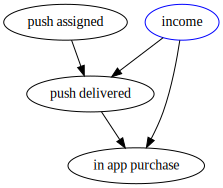

In [2]:
g = gr.Digraph()

g.edge("push assigned", "push delivered")
g.edge("push delivered", "in app purchase")
g.edge("income", "in app purchase")
g.edge("income", "push delivered")
g.node("income", color="blue")
g

인과 그래프 상단의 푸시 할당(`push assigned`)은 의도적으로 무작위 배정되었습니다. 다음으로 푸시가 전달 여부를 나타내는 노드(`push delivered`)가 있습니다. 푸시를 받도록 지정된 모든 사용자에 전달되지 않아 `compliance`를 만족하지 않습니다. (`non-compliance`) 즉, `never takers`가 있습니다: `treatment`가 할당되었음에도 `treatment`를 받지 않음. `non-compliance`는 우연이 아닙니다. 구형 스마트폰을 가진 사람들이 알림을 받지 못하므로 고객의 소득 수준이 푸시 전달에 영향을 준다고 할 수 있습니다. 부유한 고객일수록 신형 스마트폰을 가지고 있을 가능성이 높으며 푸시 알림을 받을 가능성이 높습니다. 마지막 노드는 `outcome`인 인앱 구매(`in app purchace`)입니다. 고객의 소득 `income`은 통제할 수 없는 변수임에 유의하세요. 단순히 `push assigned`를 `treatment`로 사용하면 어떻게 되는지 살펴보겠습니다.

`ATE`는 다음과 같습니다.

$
ATE = E[Y | pushAssigned=1] - E[Y | pushAssigned=0]
$

$E[Y_0|pushAssigned=0] - E[Y_0|pushAssigned=1]$가 0이라면 $E[Y_1] - E[Y_0]$에 대한 편향되지 않은 추정치입니다. `pushAssigned` 자체는 무작위로 배정되었으므로 편향이 0입니다. 그럼 해결일까요? 그렇지 않습니다. 여기서 끝낸다면 실험 의도와 다른 질문에 답하는 것입니다. 우리가 찾은 것은 `treatment`의 인과효과가 아니라 **treatment assignment** 의 인과효과입니다. 뭐가 다를까요? `treatment assignment`의 인과효과를 `ATE`라고 하면 안 될까요? 다시말해, `treatment assignment`의 인과효과는 `ATE`에 대한 편향되지 않은 추정치일까요?

결과적으로 그렇지 않습니다. `non compliance` 상황에서는 실험군과 대조군의 `output`이 비슷해집니다. 치료에 배정된 사람들의 outcome이 대조군에 배정된 사람들의 결과값과 유사하게 바뀌기 때문입니다. 비교 가능한 상태를 만들기 위해 두 그룹의 공변량을 유사하게 해야하는 것과 헷갈리면 안됩니다. `treatment effect`가 존재하지만, 실험군과 대조군의 `output`이 비슷한 상황은 원치 않습니다.

이를 확인하기위해, `Always Takers`만 있다고 해봅시다. 이 중 일부는 우연히 대조군에 배치될 것입니다. 하지만 그들은 어떻게든 `treatment`를 받습니다. 결국, 실험군과 대조군이 혼합된 집단이 만들어집니다. 이러한 혼합의 결과로 compliance가 낮은 경우 인과효과를 찾기가 더 어려워집니다.

![img](./data/img/late/always_takers.png)

같은 논리로, `Never Takers`는 항상 `treatment`를 받지 않아 실험군을 대조군처럼 보이게 합니다. 따라서, non compliance는 감지 가능한 영향을 축소하기 때문에 **`treatment assignment`의 인과효과는 0쪽으로 편향됩니다.** 극단적인 상황을 상상해보면 이해가 쉽습니다. 매우 `non compliance` 상황을 가정해봅시다. `treatment assignment`를 가지고, `treatment`(push delivered)를 예측 알 수 없습니다. 이 경우 `treatment`(push delivered) 여부는 무작위입니다. `IV` 관점에서, `treatment assigment`는 `treatment`, `in app purchase`로 이어지는 관계에서 매우 약한 `1st stage`를 갖는 상황입니다. `treatment assignment`를 `Z`라 하면 아래와 같습니다.

$
E[Y|Z=1] - E[Y|Z=0] = 0
$

`treatment assignment`은 `outcome`과 아무런 관련이 없습니다. `Z`는 그저 의미 없는 `random variable`에 불과합니다.

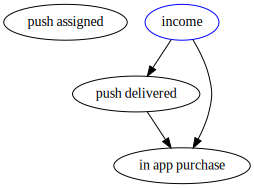

In [3]:
g = gr.Digraph()

g.node("push assigned")
g.edge("push delivered", "in app purchase")
g.edge("income", "in app purchase")
g.edge("income", "push delivered")
g.node("income", color="blue")
g

그렇다면 `treatment assigment` 대신 `treatment`(push delivered)를 사용하면 어떨까요?

$
ATE = E[Y | push=1] - E[Y | push=0]
$

다시 얻은 `ATE`가 편향되었는지, $E[Y_0|push=0] = E[Y_0|push=1]$인지 확인해야 합니다. 인과 그래프만 봐도 사실이 아니라는 것을 알 수 있습니다. `income` 등 측정할 수 없는 `confounder`가 숨어있으며 이는 인과효과를 편향시킵니다. 이미 구형 스마트폰은 푸시 알림을 받지 못한다는 사실을 알고 있습니다. 즉, $E[Y_0|push=0] < E[Y_0|push=1]$입니다. 구형 스마트폰을 가진 고객은 소득이 낮을 가능성이 있어 $push=0$이기 쉬우며 이는 잠재적인 인앱 구매 $Y_0$을 줄입니다.

`treatment assignment`나 `treatment`(push delivered)로 `ATE`를 추정할 수 없습니다. 다행히도 우리는 해결 방법을 알고 있습니다. `Instrumental Variables`(도구변수)를 사용하는 방법입니다. `treatment assignment`는 `treatment`를 위한 완벽한 `instrument`입니다. 무작위만큼 좋으며 `treatment`를 통해서만 인앱 구매를 유도합니다.

## Local Average Treatment Effect: LATE

`Local average treatment effect`(국소 평균 처치 효과)는 인과효과를 추정하는 모집단을 제한합니다. `IV`를 보는 새로운 시각입니다. 현대적인 `IV`에서는 `instrument`를 인과관계의 시작으로 봅니다. `Z`는 `T`를, `T`는 `Y`를 유발합니다. `exclusion restriction`은 `Z`가 `T`에 영향을 주지 않는 한 `Y`에도 영향을 주지 않음을 의미합니다. `1st stage`는 `T`에 대한 `Z`의 인과관계로 간주합니다. 두 개 인덱스로 다시 `potential output`를 표기합니다. 인덱스는 순서대로 `instrument`, `treatment`의 `counterfactual`를 의미합니다.

$
\text{Potential Outcome}=\begin{cases}
Y_i(1, 1) \ \text{if } T_i=1, \ Z_i=1\\
Y_i(1, 0) \ \text{if } T_i=1, \ Z_i=0\\
Y_i(0, 1) \ \text{if } T_i=0, \ Z_i=1\\
Y_i(0, 0) \ \text{if } T_i=0, \ Z_i=0\\
\end{cases}
$

`treatment`는 `1st stage`의 결과입니다. `potential output`으로 표기하면 다음과 같습니다.

$
\text{Potential Treatment}=\begin{cases}
T_0 \ \text{if } Z_i=0 \\
T_1 \ \text{if } Z_i=1
\end{cases}
$

![img](./data/img/late/double_index.png)

`Instrumental Variable`에 대한 가정은 아래와 같이 다시 쓸 수 있습니다.

1. $T_{0i}, T_{1i} \perp Z_i $ and $Y_i(T_{1i},1), Y_i(T_{0i},0) \perp Z_i $. 독립성 가정입니다. 이것은 `instrument`가 무작위로 할당된 것과 같다는 것을 말합니다. 즉, instrument인 `Z`는 `potential treatment`와 상관관계가 없으며, 이는 서로 다른 `instrument` 그룹에 속한 사람들이 비교 가능하다는 말과 동일합니다.

2. $Y_i(1, 0)=Y_i(1, 1)=Y_{i1}$ and $Y_i(0, 0)=Y_i(0, 1)=Y_{i0}$. `exclusion restriction`입니다. 처치 대상자의 `potential outcome`을 살펴보았을 때, 어떤 `instrument` 그룹에 속했는가에 상관없이 그 값이 모두 동일해야 합니다. `instrument`는 `potential outcome`에 영향을 주지 않으며, `treatment`를 통해서만 `outcome`에 영향을 줍니다.

3. $E[T_{1i}-T_{0i}] \neq 0$. `1st stage`가 존재함을 의미합니다. instrument 그룹에 따라 `1st stage`의 잠재적 결과인 `potential treatment`가 동일하지 않다는 것을 말하는 것입니다. 즉, `instrument`는 `treatment`에 영향을 줍니다.

4. $T_{i1} > T_{i0}$. 단조성 가정입니다. `instrument`가 0 일 때보다 1일 때 `treatment` 수준이 더 높습니다.

직관적인 이해를 위해 `Wald estimator`를 살펴보겠습니다.

$
ATE = \dfrac{E[Y|Z=1]-E[Y|Z=0]}{E[T|Z=1]-E[T|Z=0]}
$

$E[Y|Z=1]$는 `exclusion restriction`에 의해 `Y`로 표현할 수 있습니다.

$
E[Y_i|Z_i=1]=E[Y_{i0} + T_{i1}(Y_{i1} - Y_{i0})|Z=1]
$

독립성 가정에 따라 `Z`에 대한 조건을 제거합니다.

$
E[Y_i|Z_i=1]=E[Y_{i0} + T_{i1}(Y_{i1} - Y_{i0})]
$

또한,

$
E[Y_i|Z_i=0]=E[Y_{i0} + T_{i0}(Y_{i1} - Y_{i0})]
$

분자항은 다음과 같습니다.

$
E[Y|Z=1]-E[Y|Z=0] = E[(Y_{i1}-Y_{i0})(T_{i1}-T_{i0})]
$

단조성에 가정에 따라 $T_{i1}-T_{i0}$은 0이나 1입니다.

$
E[(Y_{i1}-Y_{i0})(T_{i1}-T_{i0})] = E[(Y_{i1}-Y_{i0})|T_{i1}>T_{i0}]P(T_{i1}>T_{i0})
$

분자항과 유사하게 분모항을 정리합니다.

$
E[T|Z=1]-E[T|Z=0]=E[T_{i1}-T_{i0}]=P(T_{i1}>T_{i0})
$

`Wald estimator`은 아래와 같습니다.

$
ATE = \dfrac{E[(Y_{i1}-Y_{i0})|T_{i1}>T_{i0}]P(T_{i1}>T_{i0})}{P(T_{i1}>T_{i0})}=E[(Y_{i1}-Y_{i0})|T_{i1}>T_{i0}]
$

`IV`로 추정한 `ATE`는 $T_{i1}>T_{i0}$를 만족하는 집단의 `ATE`입니다. `compliance`를 고려할때 어떤 집단에 해당될까요? 단조성을 만족하는 집단이므로 `compilers`에 해당합니다. 기억하기 쉽게 정리하면 다음과 같습니다.

1. Compilers: $T_{i1}>T_{i0}$
2. Never Takers: $T_{i1}=T_{i0}=0$
3. Always Takers: $T_{i1}=T_{i0}=1$

`Never Takers`나 `Always Takers`, `Defiers`는  `treatment`를 바꾸지 않아 `IV`에서 제거됩니다. **`IV`는 `compilers`에 대한 `treatment effect`만 찾습니다**.

## Effect on Engagement

인앱 구매 사례로 문제를 어떻게 해결하는지 살펴보겠습니다. 인과 그래프는 앞에서 확인했으므로 넘어가겠습니다. 수집한 데이터는 무작위로 지정된 푸시(`push_assigned`)와 전달된 푸시(`push_delivered`)로 모두 `treatment`입니다.

In [4]:
data = pd.read_csv("./data/app_engagement_push.csv")
    
data.head()

,in_app_purchase,push_assigned,push_delivered
0,47,1,1
1,43,1,0
2,51,1,1
3,49,0,0
4,79,0,0


먼저 `OLS` 결과를 확인해봅시다.

In [5]:
ols = IV2SLS.from_formula("in_app_purchase ~ 1 + push_assigned + push_delivered", data).fit()
ols.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,69.292,0.3624,191.22,0.0000,68.581,70.002
push_assigned,-17.441,0.5702,-30.590,0.0000,-18.559,-16.324
push_delivered,27.600,0.6124,45.069,0.0000,26.399,28.800


`OLS`에 따르면 `treatment effect`는 27.60입니다. 푸시 알림은 인앱 구매를 27.6 헤알 증가시킵니다. 하지만 추정치는 편향되었습니다. 구형 스마트폰은 푸시 알림을 받지 못하기 때문입니다. 신형 스마트폰 가진 부유한 고객들이 `compilers`입니다. `treatment`를 받은 사람들은 더 많은 돈을 가지므로 양의 방향으로 편향되어 푸시 알림의 영향은 더 적을 것입니다. 즉, $E[Y_0|T=0] < E[Y_0|T=1]$ 입니다.

이제 `instrument`로 인과효과를 추정해 보겠습니다. `1st stage`는 다음과 같습니다.

In [6]:
first_stage = IV2SLS.from_formula("push_delivered ~ 1 + push_assigned", data).fit()
first_stage.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,9.924e-17,1.482e-10,6.698e-07,1.0000,-2.904e-10,2.904e-10
push_assigned,0.7176,0.0064,112.07,0.0000,0.7050,0.7301


강력한 `1st stage`입니다. 71.8%가 푸시 알림을 받습니다. 푸시 알림을 받지 않는 28%는 `Never Takers`입니다. 절편값은 0이므로 `Always Takers`는 없습니다. 푸시 알림을 보내지 않으면 아무도 푸시 알림을 받지 못한다는 것을 의미하기 때문입니다. 설계상 `Always Takers`는 없는 것이 타당합니다.

이제 `reduced form`를 계산합니다.

In [7]:
reduced_form = IV2SLS.from_formula("in_app_purchase ~ 1 + push_assigned", data).fit()
reduced_form.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,69.292,0.3624,191.22,0.0000,68.581,70.002
push_assigned,2.3636,0.5209,4.5376,0.0000,1.3427,3.3845


`reduced form`에서 할당된 `treatment`의 인과효과는 2.36입니다. 푸시 알림을 할당한 사람에 대해 인앱 구매가 2.36 헤알 증가합니다.

`reduced form`를 `1st stage`로 나누면 (`treatment` 단위로 `instrument` 효과를 스케일링) $2.3636/0.7176=3.29$ 입니다. `2SLS`로 같은 추정치를 (정확한 표준 오차와 함께) 얻습니다.

In [8]:
iv = IV2SLS.from_formula("in_app_purchase ~ 1 + [push_delivered ~ push_assigned]", data).fit()
iv.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,69.292,0.3624,191.22,0.0000,68.581,70.002
push_delivered,3.2938,0.7165,4.5974,0.0000,1.8896,4.6981


`2SLS` 결과는 `OLS` 결과보다 훨씬 낮습니다. `OLS` 추정 인과효과는 양의 방향으로 편향되어 있기으므로 타당한 결론입니다. 3.29는 `compliers`에 대한 평균 인과효과입니다. `Never Takers`에 대해서는 아무런 주장을 할 수 없습니다. 신형 스마트폰을 가진 부유한 고객에 대해서만 말할 수 있을 뿐입니다.

## Key Ideas

9장에서는 도구변수에 대한 현대적인 관점을 살펴보았습니다. `IV`가 어떻게 `instrument`, `treatment`, `outcome`를 인과적 연쇄로 다루는지 공부했습니다. `IV`로 `ATE`를 추정하기 위해 `compliance`를 도입했으며 `compilers`에 대한 `LATE`를 알 수 있었습니다.

## References

I like to think of this entire book as a tribute to Joshua Angrist, Alberto Abadie and Christopher Walters for their amazing Econometrics class. Most of the ideas here are taken from their classes at the American Economic Association. Watching them is what is keeping me sane during this tough year of 2020.
* [Cross-Section Econometrics](https://www.aeaweb.org/conference/cont-ed/2017-webcasts)
* [Mastering Mostly Harmless Econometrics](https://www.aeaweb.org/conference/cont-ed/2020-webcasts)

I'll also like to reference the amazing books from Angrist. They have shown me that Econometrics, or 'Metrics as they call it, is not only extremely useful but also profoundly fun.

* [Mostly Harmless Econometrics](https://www.mostlyharmlesseconometrics.com/)
* [Mastering 'Metrics](https://www.masteringmetrics.com/)

My final reference is Miguel Hernan and Jamie Robins' book. It has been my trustworthy companion in the most thorny causal questions I had to answer.

* [Causal Inference Book](https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/)

![img](./data/img/poetry.png)


## Contribute

Causal Inference for the Brave and True is an open-source material on causal inference, the statistics of science. It uses only free software, based in Python. Its goal is to be accessible monetarily and intellectually.
If you found this book valuable and you want to support it, please go to [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true). If you are not ready to contribute financially, you can also help by fixing typos, suggesting edits or giving feedback on passages you didn't understand. Just go to the book's repository and [open an issue](https://github.com/matheusfacure/python-causality-handbook/issues). Finally, if you liked this content, please share it with others who might find it useful and give it a [star on GitHub](https://github.com/matheusfacure/python-causality-handbook/stargazers).